In [1]:
import os
import warnings
import argparse
import datetime
import pathlib
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import pickle

from test import test
from utils.evaluate_uncertainty import evaluate_uncertainty
from core.config import create_config, save_config
# from core.dataset import COCODatasetWithID
# from core.dataset_hotswapped_crop_save import COCODataset
from core.dataset_hotswapped import COCODataset
from core.model import Model
from core.metrics import AccuracyLogger
import pickle
from SupContrast.losses import SupConLoss
import torch.nn.functional as F
## Initialization

In [11]:
from tqdm import tqdm

import matplotlib.pyplot as plt

# annot_file = '../openrooms/annotation_files/train_main_xml_50_v3.json'
# annot_file = '../openrooms/annotation_files/test_main_xml_50_test_v3.json'
annot_file = '../openrooms/annotation_files/train_scannet_xml_50_v2.json'

image_dir = '../'

material_fols = ["scannet_xml_realistic", "scannet_xml_50_2"]
batch_size=15

In [12]:
dataset = COCODataset(annot_file, image_dir, (224,224), material_fols, normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])

dataloader = DataLoader(dataset, batch_size, num_workers=0, shuffle=False, pin_memory=True, drop_last=True)
from PIL import Image

Hotswapped material loader being used.
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12}
-------------------------------
Annotation Counts
-------------------------------
table                       887
sofa                        246
chair                       996
window                      290
monitor                     122
trash_bin                   164
bed                         177
lamp                         59
file_cabinet                 58
bathtub                     131
bookshelf                   140
flowerpot                     5
Total                      3275
-------------------------------



In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [14]:
unorm = UnNormalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

In [21]:
for data in tqdm(dataset):
    break

  0%|          | 0/3275 [00:00<?, ?it/s]

../openrooms/all_openrooms/scannet_xml_50/scene0001_00/im_2.png
../openrooms/stylized_all_openrooms/scannet_xml_50_2/scene0001_00/im_2.png


In [26]:
main_fol = '../openrooms/all_openrooms/scannet_xml_50/'
fol_2 = '../openrooms/stylized_all_openrooms/scannet_xml_50_2/'
fol_3 = '../openrooms/stylized_all_openrooms/scannet_xml_50_3/'
fol_4 = '../openrooms/stylized_all_openrooms/scannet_xml_realistic/'

In [27]:
def get_all_pngs(fol):
    all_pngs = []
    for scene in os.listdir(fol):
        scene_fol = os.path.join(fol,scene)
        png_files = [os.path.join(scene_fol,i) for i in os.listdir(scene_fol) if i.endswith('.png')]
        all_pngs.extend(png_files)
    return all_pngs

In [36]:
main_pngs = get_all_pngs(main_fol)
pngs_2 = get_all_pngs(fol_2)
pngs_4 = get_all_pngs(fol_4)

In [37]:
for file in main_pngs:
    if file.replace(main_fol, fol_2) in pngs_2:
        pass
    else:
        print(file)
        break

In [42]:
for file in main_pngs:
    if file.replace(main_fol, fol_4) in pngs_4:
        pass
    else:
        print(file)

In [39]:
%matplotlib inline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


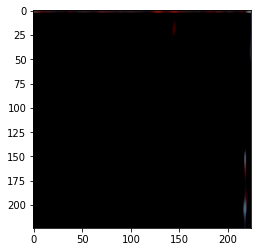

In [40]:
plt.imshow(unorm(data[1].permute(1,2,0)))
plt.show()

In [41]:
new_data_folder = '../DomainBed/domainbed/data/DGMaterials_crops/'

import json
with open(annot_file,'r') as F:
    annot_contents = json.load(F)

categories = annot_contents['categories']

cat_names = {}
for cat in categories:
    cat_names[int(cat['id'])-1] = cat['name']

In [54]:
%matplotlib inline

In [58]:
for data in tqdm(dataloader):
    impath_1, impath_2, bbox, label, annot_idx = data
    for i in range(len(impath_1)):
        imname = impath_1[i]
        image = Image.open(impath_1[i])
        image = image.convert("RGB")
        label_name = label[i]
#         new_im_name = imname.split('/')[-1].replace('.png','_%s.png'%annot_idx[i].item())
#         new_save_folder = "%s/main_xml_50_test/%s"%(new_data_folder, cat_names[label[i].item()])
#         os.makedirs(new_save_folder, exist_ok = True)
        new_save_path = "%s/%s"%(new_save_folder, new_im_name)
        xmin, ymin, w, h = bbox[0][i], bbox[1][i], bbox[2][i], bbox[3][i]
        target_image = image.crop((int(xmin), int(ymin), int(xmin + w), int(ymin + h)))
        break
    break
#         target_image.save(new_save_path)
        
#         image_2 = Image.open(impath_2[i].replace(''))
#         image_2 = image_2.convert("RGB")
#         new_save_folder_2 = new_save_folder.replace('xml_50','xml_50_test').replace('stylized_','')
#         os.makedirs(new_save_folder_2, exist_ok = True)
#         new_save_path_2 = "%s/%s"%(new_save_folder_2, new_im_name)
#         target_image_2 = image_2.crop((int(xmin), int(ymin), int(xmin + w), int(ymin + h)))        
#         target_image_2.save(new_save_path_2)

  0%|          | 0/340 [00:00<?, ?it/s]


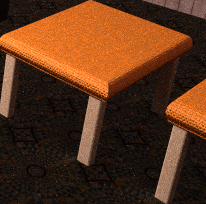

In [59]:
target_image

In [60]:
label_name

tensor(0)